In [ ]:
# Importing modules
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
file_path = "dataset/ibm.csv"
data = pd.read_csv(file_path)

print(data.head())

                        Date      Open      High       Low     Close  Volume  \
0  1962-01-02 00:00:00-05:00  1.530517  1.530517  1.513320  1.513320  407940   
1  1962-01-03 00:00:00-05:00  1.513320  1.526548  1.513320  1.526548  305955   
2  1962-01-04 00:00:00-05:00  1.526548  1.526548  1.510674  1.511336  274575   
3  1962-01-05 00:00:00-05:00  1.509353  1.509353  1.478927  1.481573  384405   
4  1962-01-08 00:00:00-05:00  1.480251  1.480251  1.441889  1.453794  572685   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


#### Data preprocessing


In [ ]:
data_filtered = data[["Date", "Open", "High", "Low", "Close", "Volume"]]
# data_filtered['Date'] = pd.to_datetime(data_filtered['Date'])
data_filtered = data_filtered.sort_values(by="Date")
data_cleaned = data_filtered.dropna()
print(data_filtered.head())

                        Date      Open      High       Low     Close  Volume
0  1962-01-02 00:00:00-05:00  1.530517  1.530517  1.513320  1.513320  407940
1  1962-01-03 00:00:00-05:00  1.513320  1.526548  1.513320  1.526548  305955
2  1962-01-04 00:00:00-05:00  1.526548  1.526548  1.510674  1.511336  274575
3  1962-01-05 00:00:00-05:00  1.509353  1.509353  1.478927  1.481573  384405
4  1962-01-08 00:00:00-05:00  1.480251  1.480251  1.441889  1.453794  572685


In [ ]:
data_cleaned.to_csv("dataset/cleaned_ibm_data.csv", index=False)

In [ ]:
file_path = "dataset/cleaned_ibm_data.csv"
data = pd.read_csv(file_path)
data.head()

,Date,Open,High,Low,Close,Volume
0,1962-01-02 00:00:00-05:00,1.530517,1.530517,1.513320,1.513320,407940
1,1962-01-03 00:00:00-05:00,1.513320,1.526548,1.513320,1.526548,305955
2,1962-01-04 00:00:00-05:00,1.526548,1.526548,1.510674,1.511336,274575
3,1962-01-05 00:00:00-05:00,1.509353,1.509353,1.478927,1.481573,384405
4,1962-01-08 00:00:00-05:00,1.480251,1.480251,1.441889,1.453794,572685


In [ ]:
# Prepare data: for Only 'Close' price is used for prediction
data_close = data["Close"].values

# Create a column vector ( N rows and 1 column)
data_close = data_close.reshape(-1, 1)

data_close

array([[  1.51332045],
       [  1.52654803],
       [  1.51133561],
       ...,
       [219.3500061 ],
       [219.72999573],
       [221.49000549]])

In [ ]:
# Normalize the data using MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_close)

In [91]:
data_scaled.shape
# the output means using 15797 rows of data with one feature that is "closing price"

(15797, 1)

The output (15797,1) means using 15797 rows of data with one feature that is "closing price"


### Preparing data to feed into LSTM model


In [ ]:
import numpy as np


def create_sequences(data, time_step):
    X = np.array([data[i : i + time_step, 0] for i in range(len(data) - time_step - 1)])
    y = np.array([data[i + time_step, 0] for i in range(len(data) - time_step - 1)])
    return X, y

In [ ]:
# Reshape the input to be [samples, time steps, features]

time_step = 60
X, y = create_sequences(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)
X.shape, y.shape

((15736, 60, 1), (15736,))

In [101]:
# Split the data into training and test sets (80% train, 20% test)

train_size = int(len(X) * 0.8)
print(train_size)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

12588


In [102]:
X_train.shape, X_test.shape

((12588, 60, 1), (3148, 60, 1))

In [ ]:
# Define the LSTM model
def create_lstm_model(time_step, features=1):
    model = Sequential()
    model.add(
        LSTM(
            units=50,
            return_sequences=True,
            input_shape=(time_step, features),
            activation="tanh",
            recurrent_activation="sigmoid",
        )
    )
    model.add(Dropout(0.2))
    model.add(
        LSTM(
            units=50,
            return_sequences=False,
            activation="tanh",
            recurrent_activation="sigmoid",
        )
    )
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    # Since a stock prediction is a regression problem, a MSE loss should be apt for this case
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model


time_steps = 60
model = create_lstm_model(time_steps)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=30)

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 7.6793e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3085e-04 - val_mean_absolute_error: 0.0090
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 7.0636e-05 - mean_absolute_error: 0.0045 - val_loss: 1.1406e-04 - val_mean_absolute_error: 0.0085
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 6.4253e-05 - mean_absolute_error: 0.0044 - val_loss: 3.2263e-04 - val_mean_absolute_error: 0.0140
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 5.8483e-05 - mean_absolute_error: 0.0042 - val_loss: 1.9368e-04 - val_mean_absolute_error: 0.0105
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 6.2804e-05 - mean_absolute_error: 0.0043 - val_loss: 2.8636e-04 - val_mean_absolute_error: 0.0130
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 5.4458e-05 - mean_absolute_error: 0.0040 - val_loss: 2.0276e-04 - val_mean_absolute_error: 0.0108
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26m

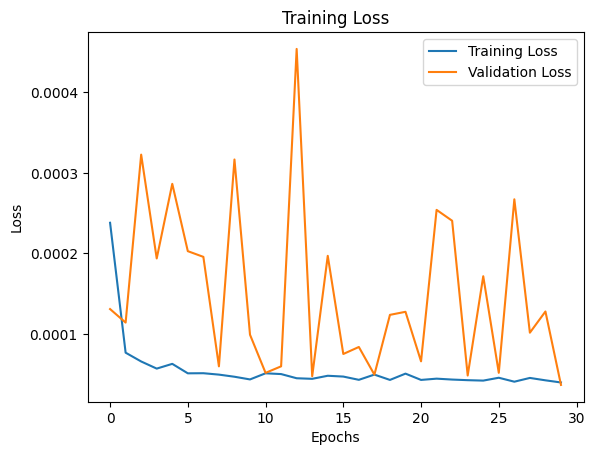

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting training and validation loss (Learning curve)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("foo.png", bbox_inches="tight")

### Trying out different models like RNN and GRU


In [ ]:
from tensorflow.keras.layers import SimpleRNN, GRU

model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(units=50, return_sequences=False))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(units=25))
model_rnn.add(Dense(units=1))

In [ ]:
# Compile the model
model_rnn.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
history_rnn = model_rnn.fit(X_train, y_train, batch_size=32, epochs=30)

Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0267
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.6442e-04
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.0062e-04
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.0687e-04
Epoch 5/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.3964e-04
Epoch 6/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.2761e-04
Epoch 7/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.7654e-04
Epoch 8/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.7189e-04
Epoch 9/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.7762e-04
Epoch 10/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.4877e-04
Epoch 11/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.4184e-04
Epoch 12/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4138e-04
Epoch 13/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.7183e-04
Epoch 14/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.4867e-04
Epoch

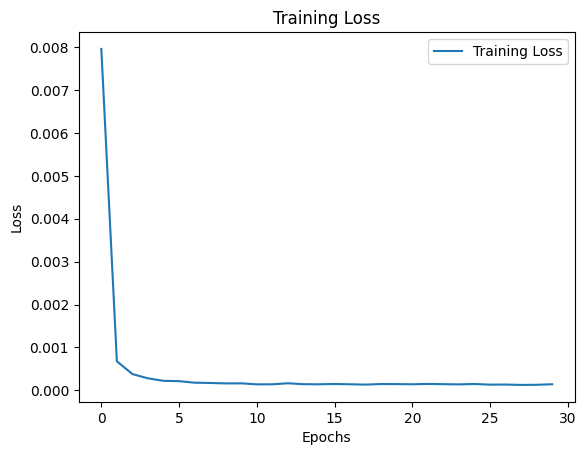

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting training loss

plt.plot(history_rnn.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("figurename.png",bbox_inches='tight')

## Intrepet the result


### Trying Gated Recurrent Unit


In [ ]:
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=50, return_sequences=False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units=25))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
history_gru = model_gru.fit(X_train, y_train, batch_size=32, epochs=30)

Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0018
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.4531e-04
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.2586e-04
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.1668e-04
Epoch 5/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.2743e-04
Epoch 6/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.2675e-04
Epoch 7/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.1647e-04
Epoch 8/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.2366e-04
Epoch 9/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.2232e-04
Epoch 10/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.1655e-04
Epoch 11/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.1880e-04
Epoch 12/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.2261e-04
Epoch 13/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.2027e-04
Epoch 14/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.

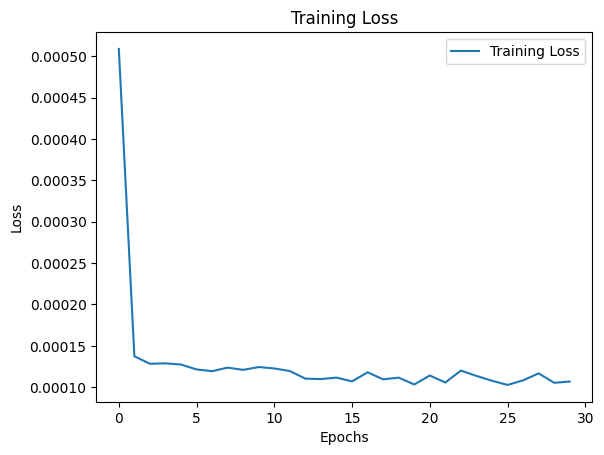

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting training loss

plt.plot(history_gru.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("foo.png", bbox_inches="tight")

### Now using LSTM model


In [ ]:
# multilayer LSTM

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
history_lstm = model_lstm.fit(X_train, y_train, batch_size=32, epochs=30)

Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0013
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.8800e-04
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.6231e-04
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.3006e-04
Epoch 5/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.4897e-04
Epoch 6/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.3906e-04
Epoch 7/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.2209e-04
Epoch 8/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.2204e-04
Epoch 9/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.1247e-04
Epoch 10/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.1423e-04
Epoch 11/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.1593e-04
Epoch 12/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.1403e-04
Epoch 13/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.1604e-04
Epoch 14/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.

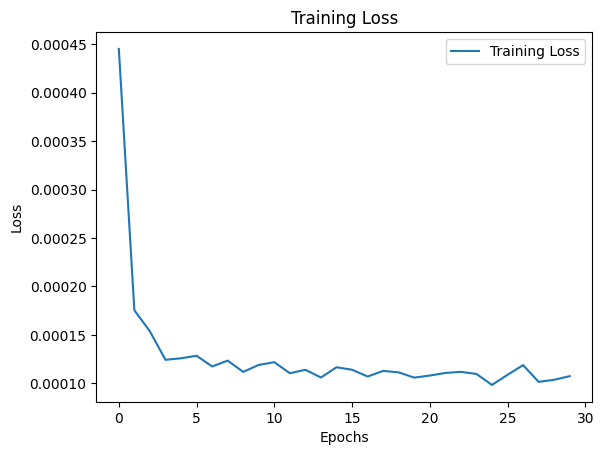

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting training loss

plt.plot(history_lstm.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("figurename.png", bbox_inches="tight")

### Now using validation while training the LSTM model


In [ ]:
history_lstm_with_validation = model_lstm.fit(
    X_train, y_train, validation_split=0.2, batch_size=32, epochs=30
)

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 5.1315e-05 - val_loss: 3.4193e-05
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.7986e-05 - val_loss: 4.0018e-05
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.9206e-05 - val_loss: 4.7711e-05
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.6308e-05 - val_loss: 3.7726e-05
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.5272e-05 - val_loss: 3.7680e-05
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.1316e-05 - val_loss: 2.8942e-04
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.3608e-05 - val_loss: 4.0322e-04
Epoch 8/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.6517e-05 - val_loss: 8.5877e-05
Epoch 9/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.3440e-05 - val_loss: 4.8663e-05
Epoch 10/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.3861e-05 - val_loss: 4.0417e-05
Epoch 11/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/

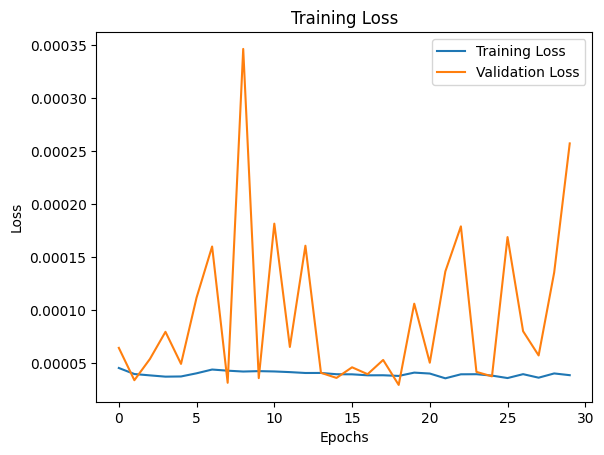

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting training and validation loss

plt.plot(history_lstm_with_validation.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("foo.png", bbox_inches="tight")

In [ ]:
history_gru_with_validation = model_gru.fit(
    X_train, y_train, validation_split=0.2, batch_size=32, epochs=30
)

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 4.8049e-05 - val_loss: 1.6660e-04
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 4.0688e-05 - val_loss: 3.0027e-05
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 4.0108e-05 - val_loss: 2.8228e-05
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 4.0925e-05 - val_loss: 6.1663e-05
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.8008e-05 - val_loss: 1.2180e-04
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.8071e-05 - val_loss: 1.0211e-04
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.9838e-05 - val_loss: 2.6454e-05
Epoch 8/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.9920e-05 - val_loss: 4.2575e-05
Epoch 9/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 4.0742e-05 - val_loss: 4.0493e-05
Epoch 10/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 4.0770e-05 - val_loss: 1.2415e-04
Epoch 11/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/

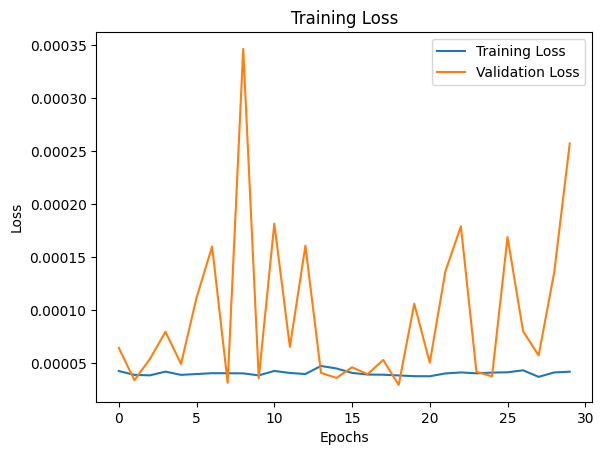

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting training and validation loss

plt.plot(history_gru_with_validation.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("figurename.png", bbox_inches="tight")

### Result Intrepretation

If we tried validating while training, the learning is not good so , we proceed without using validation


## Testing the model on RNN


In [ ]:
# Predict stock prices on the test set
predicted_stock_price = model_rnn.predict(X_test)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# getting actual stock price by inverse transforming the actual predicted stock price

predicted_stock_price_original = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

#### Calculating Error Metrices (MSE, RMSE and MAE)


In [ ]:
# getting modules from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, predicted_stock_price_original)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_original)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 6.3824414153912805
Root Mean Squared Error (RMSE): 2.5263494246424583
Mean Absolute Error (MAE): 1.7811122661624506


## Testing the model on GRU


In [ ]:
predicted_stock_price = model_gru.predict(X_test)
predicted_stock_price_original = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# getting modules from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, predicted_stock_price_original)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_original)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Squared Error (MSE): 4.5969585972852745
Root Mean Squared Error (RMSE): 2.144051911051893
Mean Absolute Error (MAE): 1.5320699611794695


### Testing the model on LSTM


In [ ]:
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price_original = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# getting modules from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, predicted_stock_price_original)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_original)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 124.65827659332606
Root Mean Squared Error (RMSE): 11.165047093197863
Mean Absolute Error (MAE): 8.039994994748804


### Our main target is to make LSTM model better at predicting so lets work more on LSTM to make it much better.

### Lets try hyperparamters tuning

#### I try to use tanh and see the peformance based on the professor recommendation


In [ ]:
lstm_model = Sequential()
lstm_model.add(
    LSTM(units=50, activation="tanh", return_sequences=True, input_shape=(time_step, 1))
)
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, activation="tanh", return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(
    Dense(units=1, activation="linear")
)  # Output layer with linear activation for unrestricted output

# model.add(Dense(units=1, activation='tanh'))  # if output values are expected within [-1, 1]


lstm_model.compile(optimizer="adam", loss="mean_squared_error")

/Users/asimmahat/.local/share/virtualenvs/stock_market_prediction-uzxGUPKk/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history_lstm_model_optimized = lstm_model.fit(
    X_train, y_train, batch_size=32, epochs=30
)

Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0012
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.8872e-04
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.5499e-04
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.4689e-04
Epoch 5/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.1962e-04
Epoch 6/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.2372e-04
Epoch 7/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.1662e-04
Epoch 8/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.2154e-04
Epoch 9/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.1821e-04
Epoch 10/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.0970e-04
Epoch 11/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.6584e-04
Epoch 12/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.1556e-04
Epoch 13/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.0627e-04
Epoch 14/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.

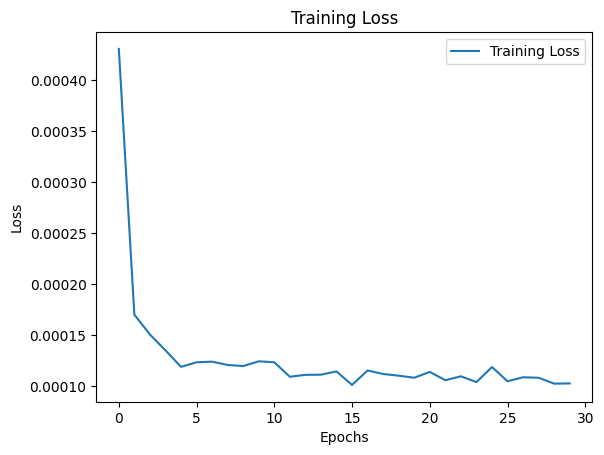

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history_lstm_model_optimized.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("foo.png", bbox_inches="tight")

### Lets train with validation loss


In [ ]:
history_lstm_model_optimized_with_validation = lstm_model.fit(
    X_train, y_train, validation_split=0.2, batch_size=32, epochs=30
)

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 4.7208e-05 - val_loss: 3.3185e-05
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.9974e-05 - val_loss: 1.2218e-04
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.7434e-05 - val_loss: 3.9162e-04
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.6783e-05 - val_loss: 7.1513e-05
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.8570e-05 - val_loss: 9.4726e-05
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 4.1530e-05 - val_loss: 8.1157e-05
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.6077e-05 - val_loss: 4.8363e-05
Epoch 8/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.6275e-05 - val_loss: 3.2174e-05
Epoch 9/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 4.2250e-05 - val_loss: 4.0345e-05
Epoch 10/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.9827e-05 - val_loss: 1.9390e-04
Epoch 11/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/

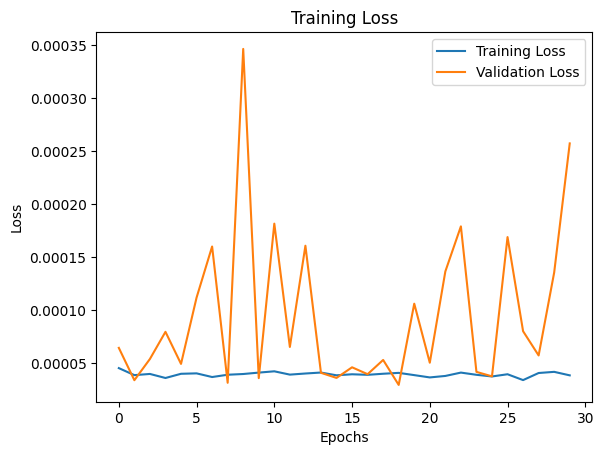

<Figure size 640x480 with 0 Axes>

In [ ]:
# Learning curve

plt.plot(
    history_lstm_model_optimized_with_validation.history["loss"], label="Training Loss"
)
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("figurename.png", bbox_inches="tight")

In [ ]:
dates = data["Date"].values

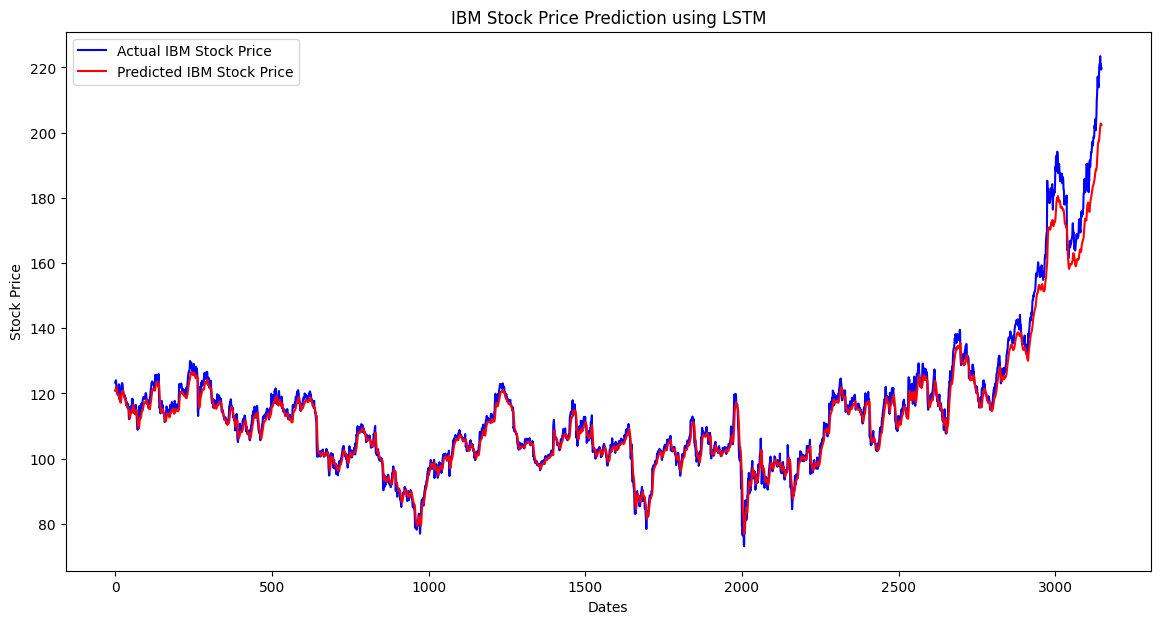

In [ ]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_original, color="red", label="Predicted IBM Stock Price")
plt.title("IBM Stock Price Prediction using LSTM")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()